In [1]:
import polars as pl

In [2]:
enso = pl.read_csv('../../data_sprint_2025/ocean_climate_oscillations.csv.gz')
data = pl.read_csv('../../data_sprint_2025/dengue.csv.gz')

enso = enso.with_columns(pl.col("date").str.to_date("%Y-%m-%d"))
data = data.with_columns(pl.col("date").str.to_date("%Y-%m-%d"))
data = data.select("date").unique()

# Find the largest date in enso
max_enso_date = enso.select(pl.col("date").max()).item()
data = data.filter(pl.col("date") <= max_enso_date)

enso = enso.join(data, on="date", how="full")
enso = enso.with_columns(
    pl.when(pl.col("date_right").is_not_null())
    .then(pl.col("date_right"))
    .otherwise(pl.col("date"))
    .alias("date")
).drop("date_right").sort('date')

In [3]:
# Interpolate missing values in enso using polars
enso_interpolated = enso.sort("date").with_columns(
    [
        pl.col("enso").interpolate().alias("enso"),
        pl.col("iod").interpolate().alias("iod"),
        pl.col("pdo").interpolate().alias("pdo"),
    ]
)
enso_interpolated

date,enso,iod,pdo
date,f64,f64,f64
1993-01-04,1.12037,-0.339384,0.816528
1993-01-11,1.212844,0.036703,1.069586
1993-01-17,1.147867,0.044273,0.671869
1993-01-24,1.001203,-0.160355,0.543553
1993-01-31,1.051898,-0.420325,1.431639
…,…,…,…
2025-02-09,-0.829043,-1.925059,0.630016
2025-02-16,-0.762369,-1.645216,0.296623
2025-02-23,-0.807978,-1.394405,0.351848


In [5]:
enso_interpolated.write_parquet('../data/enso_interpolated.parquet')

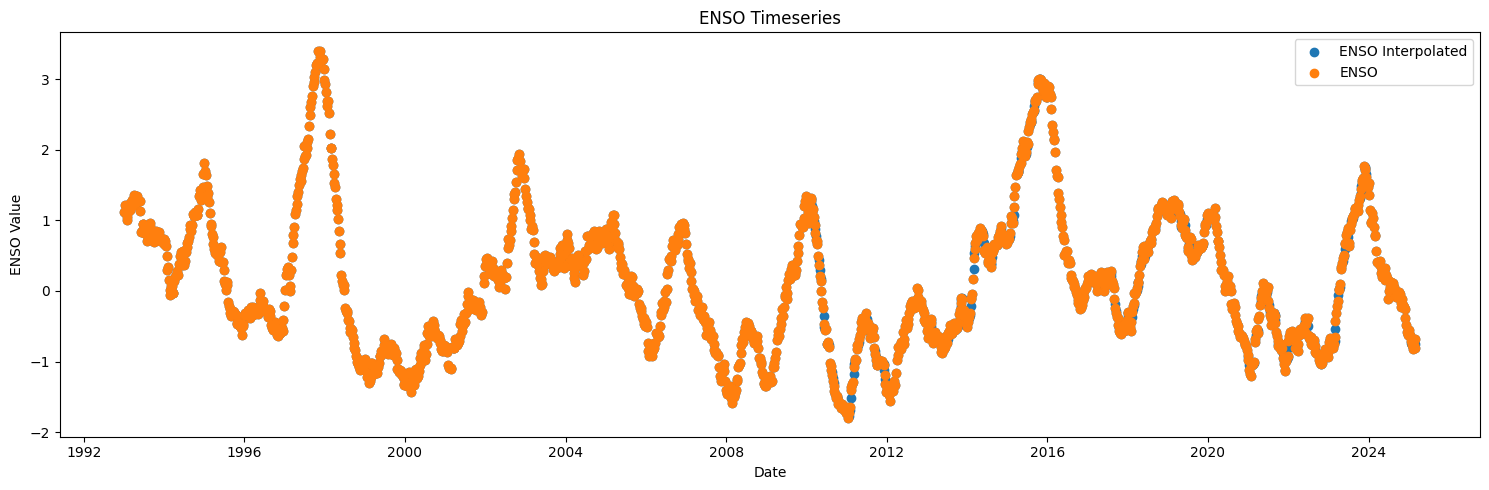

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.scatter(enso_interpolated["date"].to_pandas(), enso_interpolated["enso"].to_pandas(), label="ENSO Interpolated")
plt.scatter(enso["date"].to_pandas(), enso["enso"].to_pandas(), label="ENSO")
plt.xlabel("Date")
plt.ylabel("ENSO Value")
plt.title("ENSO Timeseries")
plt.legend()
plt.tight_layout()
plt.show()
